## Introduction to Dynamic circuits

Dynamic circuits are a groundbreaking advancement in quantum computing that enable the integration of real-time classical communication within quantum circuits. Unlike static circuits, where quantum operations are predetermined and independent of runtime data, dynamic circuits incorporate classical processing during the coherence time of qubits. This allows for mid-circuit measurements and feed-forward operations, where the outcomes of measurements dictate subsequent gate applications. dynamic circuits offer a bridge between classical and quantum computation by leveraging classical information to dynamically adjust the quantum operations performed within a circuit. This capability significantly expands the range of quantum algorithms and applications that can be implemented on near-term quantum hardware. By optimizing the trade-off between circuit depth and width, dynamic circuits pave the way for more efficient and effective quantum computations, potentially unlocking quantum advantage in various domains

 In statistical mechanics and thermodynamics, the Gibbs state free energy, denoted as

- F, is a fundamental quantity that characterizes the equilibrium state of a thermodynamic system at constant temperature

- T, pressure

- P, and particle number

- N. It is defined as the difference between the internal energy

- U and the product of temperature

- T and entropy

- S, i.e.,
$F=U-TS$

The Gibbs free energy plays a crucial role in various areas of physics, chemistry, and engineering. Some key aspects of its importance include:

- Thermodynamic Stability: In a closed system at constant temperature and pressure, a process will occur spontaneously if and only if the change in Gibbs free energy is negative
- Chemical Reactions: The Gibbs free energy change $(\Delta G)$ for a chemical reaction determines whether the reaction is thermodynamically favorable $(\Delta G < 0)$ or unfavorable $(\Delta G > 0)$. It helps predict the feasibility and direction of chemical reactions under given conditions.

- Phase Transitions: At phase equilibrium, the Gibbs free energies of coexisting phases are equal. The Gibbs free energy change between different phases $(\Delta G_{\text{phase}})$ governs phase transitions such as melting, vaporization, and sublimation.

- Equilibrium Conditions: The Gibbs free energy is minimized at equilibrium, providing a criterion for determining the equilibrium state of a system. At equilibrium, the chemical potential $(\mu)$ of each component is equal across phases $(\mu_i^{\alpha} = \mu_i^{\beta})$, ensuring a balance of chemical potentials.
- Reference - [Image](https://byjus.com/jee/gibbs-free-energy/)

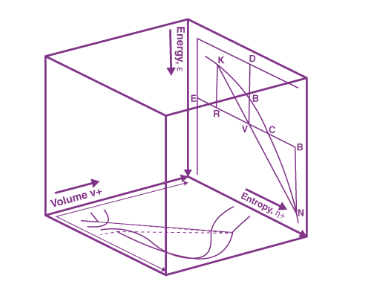

## We start with importing and installing the required Packages

In [ ]:
# General imports
import numpy as np
import random
!pip install qiskit
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister, transpile

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime
!pip install qiskit_ibm_runtime
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Get a fake backend from the fake provider
!pip install qiskit_aer
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# Parameterized circuit
from qiskit.circuit import Parameter

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
!pip install pylatexenc
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings("ignore")


## Calculating Gibbs Free energy using Variational Quantum eigensolver
- We have used The Transverse Field Ising Model (TFIM) Hamiltonian describes a system of quantum spins interacting with each other under the influence of an external magnetic field. The Hamiltonian for the TFIM is given by.
 - This Hamiltonian describes the interplay between the interaction energy (first term) that tends to align neighboring spins either parallel or antiparallel, and the external magnetic field energy (second term) that tends to align spins along the x-axis.Adjusting the values of N, J, and h allows for the exploration of different system sizes, interaction strengths, and external field strengths.

- Figure - Transverse Field Ising Model Hamiltonian

 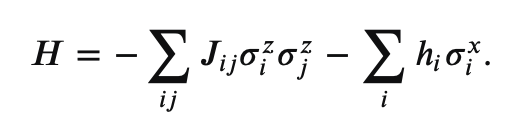

SparsePauliOp(['IZZ', 'ZZI', 'IIX', 'IXI', 'XII'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

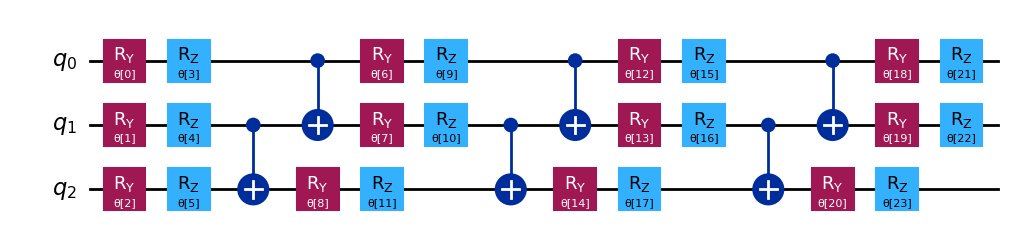

In [ ]:
# Define Spin-1/2 Hamiltonian and Variational Ansatz
num_sites = 3
J = 1
h = -1

oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))

hamiltonian = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)
display(hamiltonian)
ansatz = EfficientSU2(hamiltonian.num_qubits)
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters

We then Construct the initial and final Hamiltonians for the TFIM with adjustable parameters.Here are the steps
-  Initialize Parameters
- num-sites = 3: Number of sites or spins in the system.
- J = 1: Coupling constant for spin-spin interaction.
- h = 1: Strength of external magnetic field along the x-direction
- Create an operator list oplist
- Use SparsePauliOp.from-sparse-list() to create the initial Hamiltonian hamiltonian-i
- Update the external magnetic field strength h to a new value (e.g., h = 1.5)
- Repeat the construction process to create the final Hamiltonian hamiltonian-f
- Add interaction terms $\sigma_i^z \sigma_{i+1}^z$ and external field term $\sigma_i^x$ to \texttt{oplist}.

we utilized the EfficientSU2 ansatz to initialize the circuit structure, where
the number of parameters was determined by the attribute num-params.

In [ ]:
# Defien free energy calculation to be minimize based on ansatz parameters
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler):
    free_energy = 0

    # Expectation value of H
    e_pub = (ansatz, [hamiltonian], [params])
    energy = estimator.run(pubs=[e_pub]).result()[0].data.evs[0]
    free_energy += energy-3/(2*beta)

    n_shots = 1024

    # Calculation and post-processing of Tr(rho^2)
    s_pub = (tr_rho2,[params],n_shots)
    job2 = sampler.run(pubs=[s_pub]).result()[0].data.clbit.get_counts()
    try:
        R2 = job2['0']/n_shots - job2['1']/n_shots
    except:
        R2 = 1
    free_energy += (2/beta)*R2

    # Calculation and post-processing of Tr(rho^3)
    s_pub = (tr_rho3,[params],n_shots)
    job3 = sampler.run(pubs=[s_pub]).result()[0].data.clbit.get_counts()
    try:
        R3 = job3['0']/n_shots - job3['1']/n_shots
    except:
        R3 = 1
    free_energy += (-1/(2*beta))*R3

    return free_energy


## Calculating Gibbs Free energy using Dynamic Circuits
- We started by defining the Hamiltonian,  Spin-1/2 Hamiltonian is defined using the Transverse Field Ising Model (TFIM) Hamiltonian. This model describes a system of spin-1/2 particles with interactions between neighboring spins and an external magnetic field. The Hamiltonian is constructed using the qiskit.quantum-info.SparsePauliOp class, which allows us to represent Hamiltonians in terms of Pauli operators efficiently.  
 - we defined an ansatz circuit using the EfficientSU2 class provided by Qiskit. An ansatz circuit is a parameterized quantum circuit used to prepare trial states for variational quantum algorithms. The EfficientSU2 ansatz is a common choice for variational quantum algorithms as it provides a flexible and efficient way to explore the Hilbert space of the quantum system. The number of parameters in the ansatz circuit determines the expressiveness of the trial states and influences the accuracy of the results obtained from the variational algorithm.

we formulated a cost function equation for the minimization method.
This equation, derived from the Gibbs Free Energy expression, involves
the Hamiltonian H and the density matrix ρ of the system. By
minimizing this equation with respect to the parameters θ of the
ansatz circuit, we aim to determine the Gibbs Free Energy associated
with the measured Hamiltonian.
- Figure: Cost function equation

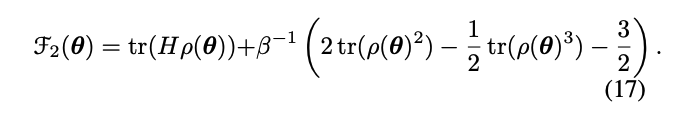

In [ ]:
# Define Callback Function
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


- cost function (cost-func) is defined. This function takes as input the parameters of the ansatz circuit, the Hamiltonian, and other necessary components such as the estimator and sampler.
- The cost function computes the estimated free energy based on the Hamiltonian, ansatz parameters, and additional components such as expectation values obtained from the sampler.
- Another function (build-callback) is defined to serve as a callback during the optimization process.
This callback function stores intermediate cost values and parameters during the optimization iterations.
It helps monitor the progress of the optimization and provides feedback on the current cost and iteration count..
- Two quantum circuits $( \text{tr\_rho2} )$ and $( \text{tr\_rho3} )$ are defined for the calculation of expectation values $( \text{Tr}(\rho^2) )$ and $( \text{Tr}(\rho^3) )$.

- These circuits utilize mid-circuit measurements and resets to compute certain operator expectations necessary for estimating the free energy.

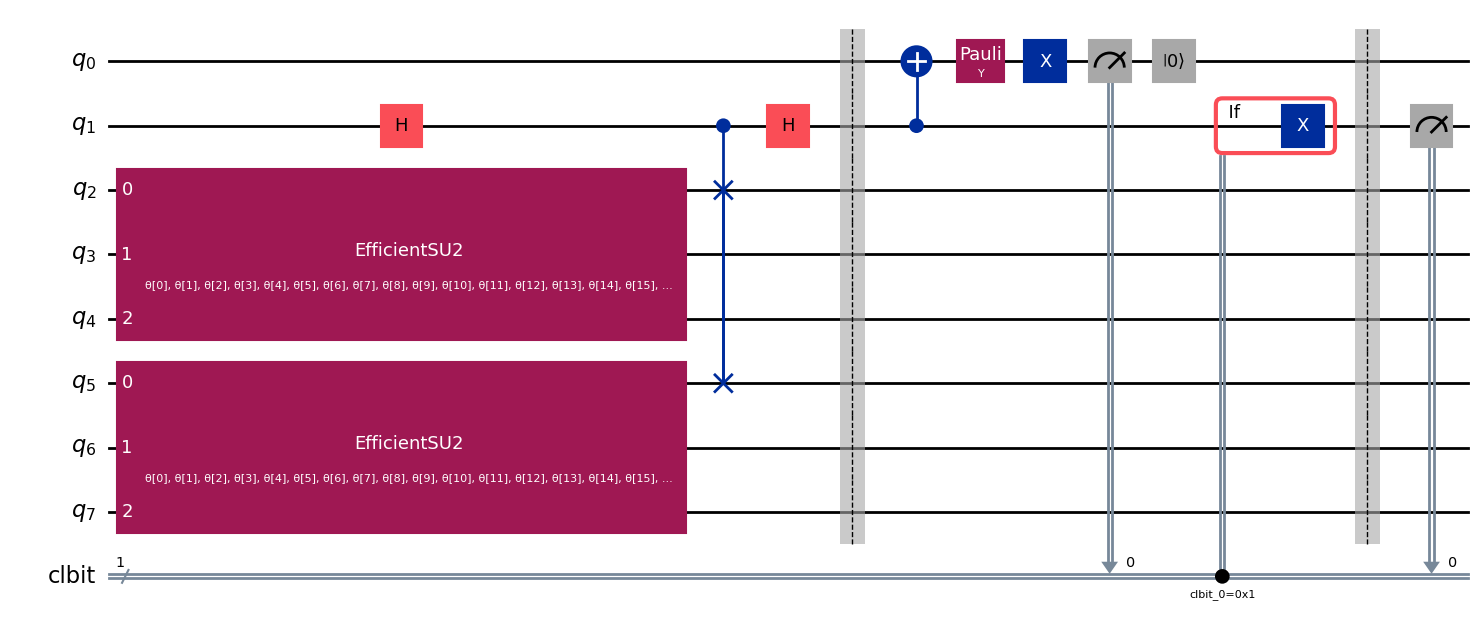

In [ ]:
# Define SWAP test circuit used in Tr(rho^2) calcultion

qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho2 = QuantumCircuit(2*num_sites+2)
tr_rho2 = tr_rho2.compose(auxs, [0,1])
tr_rho2.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho2.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho2.h(1)
tr_rho2.cswap(1,2,num_sites+2)
tr_rho2.h(1)

tr_rho2.barrier()

N = 1
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho2.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho2.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho2.x(0)
    tr_rho2.measure(0,0)
    tr_rho2.reset(0)
    with tr_rho2.if_test((0, 1)):
        tr_rho2.x(1)
    tr_rho2.barrier()

tr_rho2.measure(1,0)

display(tr_rho2.draw("mpl", style="iqp"))


- Using the minimize function from SciPy, the cost function is minimized with respect to the parameters of the ansatz circuit.
- The optimization process iteratively adjusts the parameters of the ansatz circuit to minimize the cost function, which in turn estimates the free energy of the system.
- Preparing the quantum circuit for computing $( \text{Tr}(\rho^3) )$. In the circuit, the unitary $( U(\theta) )$ denotes the state preparation circuit, and $( H )$ denotes the Hadamard gate. Four registers are used to prepare states by $( U(\theta) )$, and one ancillary qubit is used to perform the controlled swap operator. The qubit reset occurs on the bottom two registers, where the break in the wire means the reset operation. Notably, the state on the bottom two registers is first implemented with a circuit $( U(\theta) )$ and a controlled swap operator and then reset to state $( |0\rangle )$. Again, $( U(\theta) )$ and a controlled swap operator are performed on the bottom registers. Finally, $( \text{Tr}(\rho^3) )$ can be obtained via post-processing the measurement results

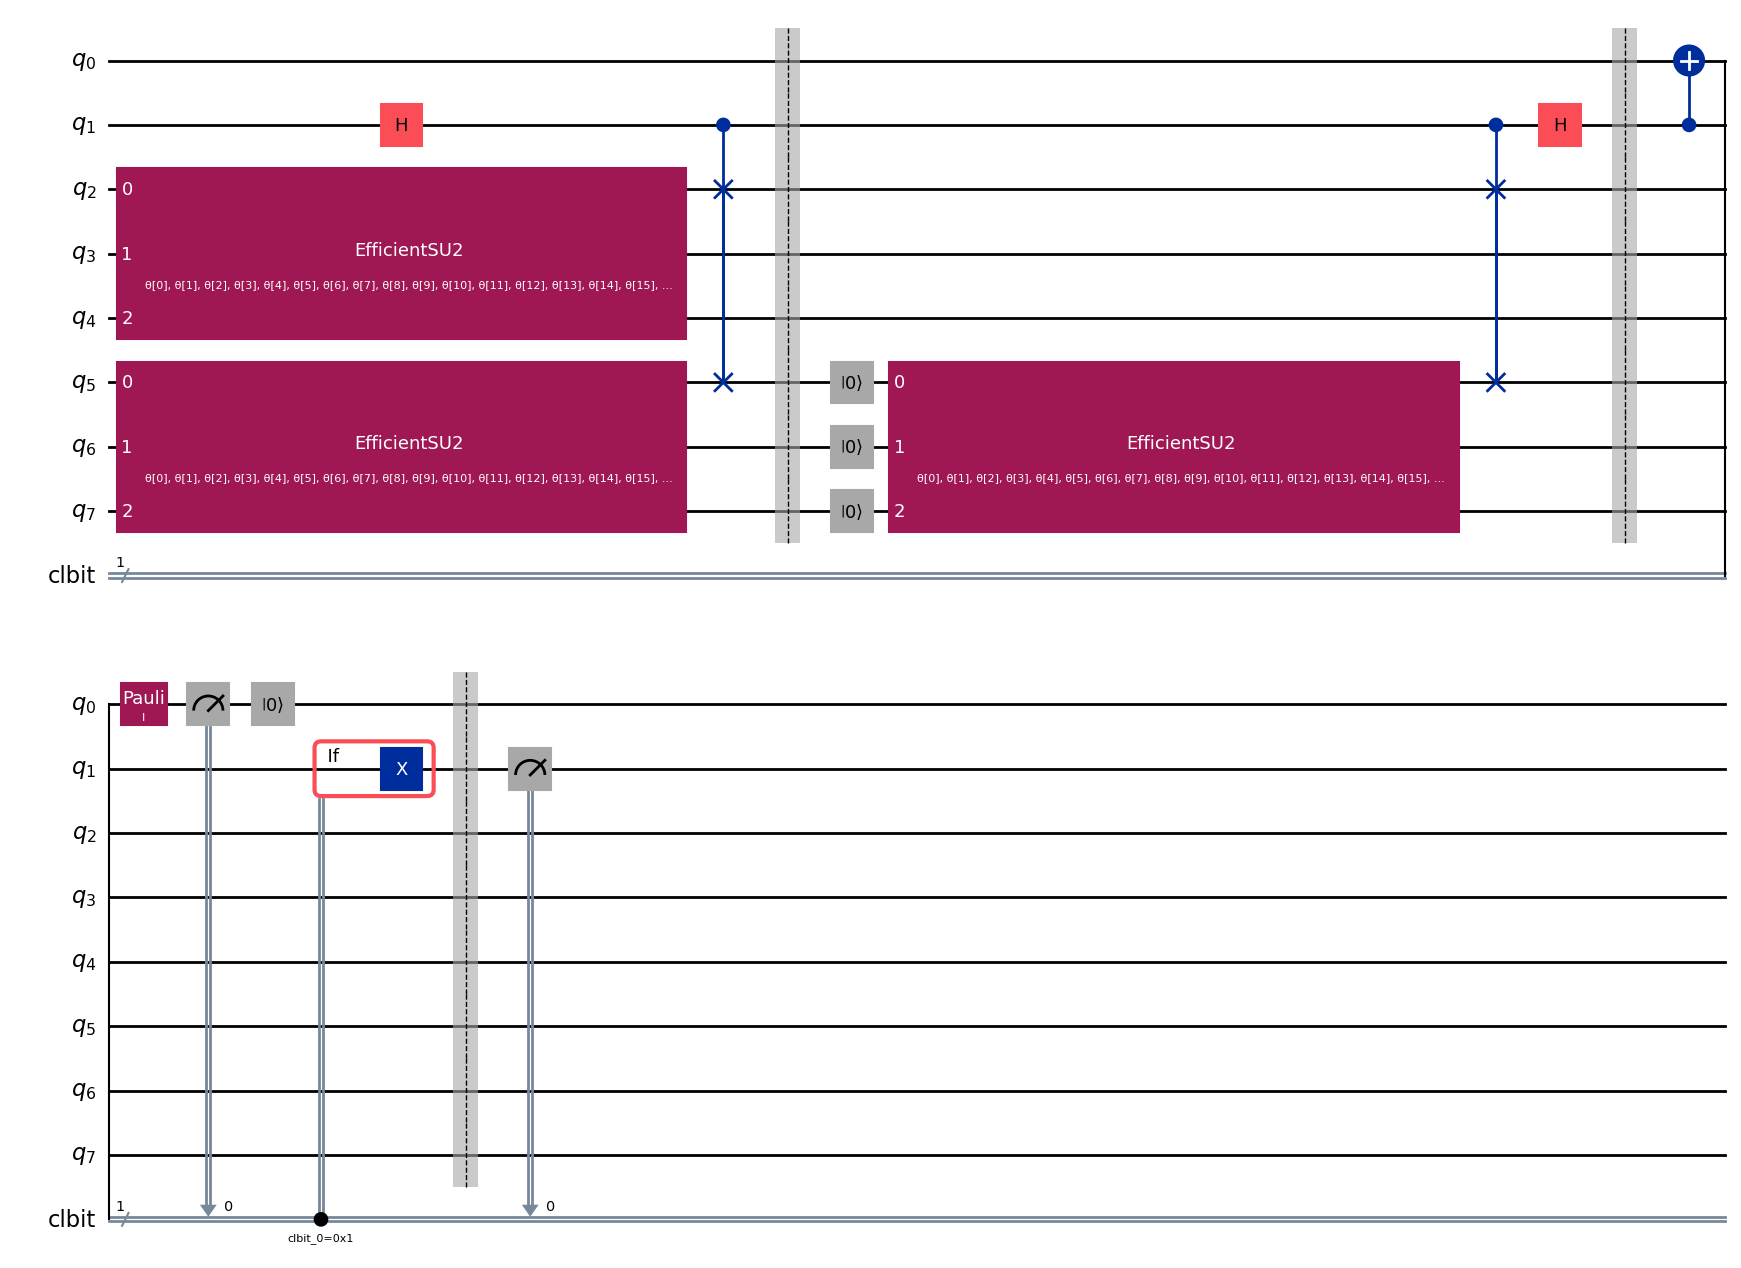

In [ ]:
# Define SWAP test circuit used in Tr(rho^3) calcultion using mid-circuit measurment and reset
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho3 = QuantumCircuit(2*num_sites+2)
tr_rho3 = tr_rho3.compose(auxs, [0,1])
tr_rho3.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.h(1)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.barrier()
tr_rho3.reset([2+num_sites+i for i in range(num_sites)])
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.h(1)

tr_rho3.barrier()

N = 1
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho3.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0,0)
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

tr_rho3.measure(1,0)

display(tr_rho3.draw("mpl", style="iqp"))


- We initialized a callback-dict to keep track of iteration data such as
the previous parameter vector, iteration count, and cost history. We
randomly initialized the parameters x0 within the range of
[0, 2π) to kickstart the optimization process.We instantiated an
Estimator and a Sampler to estimate expectation values and sample
from quantum circuits, respectively.
  - We constructed a callback
function callback using the build-callback method. This function is
used to monitor the optimization process, update the iteration count,
and record the cost history during optimization. We used the minimize
function from SciPy to minimize the cost-func with respect to the
ansatz parameters. We provided initial parameters x0, along with
other necessary arguments such as the ansatz, state preparation
circuits (tr-rho2 and tr-rho3), Hamiltonian, beta value, estimator,
sampler, and the callback function


Figure - Schematic representation of the variational quantum Gibbs
state preparation


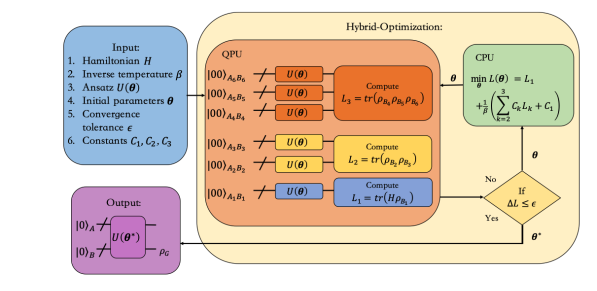

In [ ]:
# For running local Simulation
local = True
if local:
    # Specify a system to use for the noise model
    # service = QiskitRuntimeService(channel="ibm_quantum", token="")
    # real_backend = service.backend("ibm_kyoto")
    # backend = AerSimulator.from_backend(real_backend)
    backend = AerSimulator()
    # backend = GenericBackendV2(num_qubits=2*num_sites+2,control_flow=True)
    display(f"Local Simulator Backend: {backend.name}")
else:
    # To run on hardware, select the backend with the fewest number of jobs in the queue
    service = QiskitRuntimeService(channel="ibm_quantum", token="")
    #service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.least_busy(operational=True, simulator=False)
    display(f"Quantum Cloud Backend: {backend.name}")

'Local Simulator Backend: aer_simulator'

In [ ]:
# Minimize the cost function with respect to the ansatz parameters

callback_dict = {
    "prev_vector": {},
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
beta = 1.5

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)
tr_rho2_isa = pm.run(tr_rho2)
tr_rho3_isa = pm.run(tr_rho3)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

if local:
    estimator = Estimator(backend=backend)
    sampler = Sampler(backend=backend)

    callback = build_callback(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler, callback_dict)

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler),
        method="cobyla",
        callback=callback,
        options={'maxiter':400}
    )
else:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        sampler = Sampler(session=session)

        callback = build_callback(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler, callback_dict)

        res = minimize(
            cost_func,
            x0,
            args=(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler),
            method="cobyla",
            callback=callback,
            options={'maxiter':1}
        )
display(f'Calculated Free Energy: {cost_func(res.x, ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler)}')



'Calculated Free Energy: -3.1699218750000004'


We compute the fidelity between the state produced by the ansatz
circuit and a reference ground state. The ground state is obtained by
finding the eigenvectors of the Hamiltonian and selecting the one
corresponding to the lowest eigenvalue.
We print the fidelity between the ansatz state and the ground state,
indicating how close the ansatz state is to the true ground state. Fidelity between ansatz state and
ground state

In [ ]:
from qiskit.quantum_info import Statevector, state_fidelity

# Define a reference state (for example, the ground state of the Hamiltonian)
hamiltonian_matrix = hamiltonian.to_matrix()
eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
ground_state_vector = eigenvectors[:, np.argmin(eigenvalues)]
reference_state = Statevector(ground_state_vector)

# Compute the state produced by the ansatz circuit
bound_ansatz_circuit = ansatz.assign_parameters(res.x)
ansatz_state = Statevector.from_instruction(bound_ansatz_circuit)

# Compute the fidelity between the ansatz state and the reference state
fidelity = state_fidelity(ansatz_state, reference_state)
print(f'Fidelity between ansatz state and ground state: {fidelity}')

Fidelity between ansatz state and ground state: 0.9068520923356903


## References

- Quasi-Probabilistic Readout Correction of Mid-Circuit
Measurements for Adaptive Feedback via Measurement
Randomized Compiling Akel Hashim, Arnaud Carignan-Dugas,
Larry Chen, Christian Juenger, Neelay Fruitwala, Yilun Xu, Gang
Huang, Joel J. Wallman, Irfan Siddiqi
- Variational quantum Gibbs state preparation with a truncated
Taylor series Youle Wang,1, 2 Guangxi Li,1, 2 and Xin Wang1, 1
Institute for Quantum Computing, Baidu Research, Beijing
100193, China 2Centre for Quantum Software and Information,
University of Technology Sydney, NSW 2007, Australia
- Journal Club: Quasi-Probabilistic Readout Correction of
Mid-Circuit Measurements for Adaptive Feedback via
Measurement Randomized Compiling QPRC Model image taken
from Unitary fund talk slides